In [1]:
# Due the different version of python can be found and each machine or libriries 
# I just decided to use this library to avoid distraction and anoing warnigs
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

## Licence of use

Working with Room Occupancy Estimation: That dataset was collected from UCI Machine Learning Repository -https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation
licence by Creative Commons Attribution 4.0 (CC BY 4.0) https://creativecommons.org/licenses/by/4.0/

## About the dataset

    -> The experimental testbed for occupancy estimation was deployed in a 6m x 4.6m room. The setup consisted of 7 sensor nodes and one edge node in a star configuration with the sensor nodes transmitting data to the edge every 30s using wireless transceivers.
    -> The data was collected for a period of 4 days in a controlled manner with the occupancy in the room varying between 0 and 3 people. The ground truth of the occupancy count in the room was noted manually.

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local") \
    .appName("Occupancy Estimation") \
    .getOrCreate()

24/03/27 15:07:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
# Loading dataset from HDFS - Biga data Tecnology to storage
df = spark.read.csv("hdfs:///user1/Occupancy_Estimation.csv", header=True, inferSchema=True)

# Data Exploration
    - as EDA

In [ ]:
# Print the schema to understand the data types
df.printSchema()

# Summary statistics for numerical columns
df.describe().show()

# Preprocessing the dataset with PySpark 
    
     - Checking for Missing Values
     - Cleaning features that won't be used by the LSTM --> Feature Engineering
     - Converting to a Pandas Df to preprocecing
     - Normalization

In [ ]:
from pyspark.sql.functions import col, count

# Count the total number of entries
total_entries = df.count()

# Count the number of non-null (non-missing) values in each column
non_missing_counts = df.agg(*(count(c).alias(c) for c in df.columns))

# To view the results
non_missing_counts.show()

# Calculating missing values by subtracting non-missing from total entries
# This involves converting the DataFrame to a Pandas DataFrame for easier manipulation
non_missing_counts_pandas = non_missing_counts.toPandas()
missing_values = total_entries - non_missing_counts_pandas.iloc[0]
print("Missing values in each column:\n", missing_values)


# Features and Target

 - Target is predict Room Ocuppancy which is(Room_Occupancy_Count)
 - All the sensors readings would be the features to be analysed
 - Let's perform a better Feature Engineering - separating onto differents df

In [5]:
# Separating features and target variable - This step here it's just to don't go and just drop features.
feature_columns = [col for col in df.columns if col not in {'Date', 'Time', 'Room_Occupancy_Count'}]
features_df = df.select(*feature_columns)
target_df = df.select('Room_Occupancy_Count')

In [6]:
# features_df and target_df are a Spark DataFrames also, convert those to Pandas for normalization(Features)
pandas_features_df = features_df.toPandas()
pandas_target_df = target_df.toPandas()

In [7]:
# Normalizing the data
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler for features
scaler_features = MinMaxScaler(feature_range=(0, 1))
# Fit and transform the features
pandas_features_df_scaled = pd.DataFrame(scaler_features.fit_transform(pandas_features_df),
                                         columns=pandas_features_df.columns)

scaler_target = MinMaxScaler(feature_range=(0, 1))
# As the target Df is a single column and needs to be reshaped for scaling
pandas_target_df_scaled = scaler_target.fit_transform(pandas_target_df.values.reshape(-1, 1))
# Flatten back to a series maintaining the original index
pandas_target_df_scaled = pd.Series(pandas_target_df_scaled.flatten(), index=pandas_target_df.index)

# pandas_features_df_scaled -> Normalized features
# pandas_target_df_scaled -> Normalized target 


Inverse Transformation will be needed because as I normalized the target variable, keep the scaler_target object so it will needs later  to use scaler_target.inverse_transform() on top of predictions, in order to interpret the results in the original scale of the target variable.

# Autocorrelation and time steps

    Each observation in this dataset was measured every 30 seconds, in order to capture trends or patterns
    within a 30-minute window, has to follow the formula
### (30 × 60) ÷ 30 = <code>60 time steps.</code> (reading is 30min times 60 seconds divided by 30 seconds)

In [ ]:
# To understand whcih steps would be better to the model with that data set.

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# `pandas_target_df` is a Pandas df before normalization of target variable
plot_acf(pandas_target_df, lags=60)
plt.show()

## Preparation to aproach  a LSTM model

    Transforming feature and target data into sequences as we have time series data.
    This process involves using all data available to create sequences that LSTM model can learn from it.

In [8]:
#function for creating sequences

def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Let's call the function 
# pandas_features_df_scaled is the features DataFrame after scaling
# and pandas_target_df (or pandas_target_df_scaled) is target variable

time_steps = 60  # Adjusted based on the temporal dependency analysis which it's seem previously

target_df_used_for_sequences = pandas_target_df_scaled
X, y = create_sequences(pandas_features_df_scaled, target_df_used_for_sequences, time_steps=time_steps)


In [11]:
# Splitting time series data for LSTM models, ensuring the split preserves the sequence's temporal order
# Determine the split point for an 80/20 train-test split

# Determine the split point for an 80/20 train-test split
split_point = int(len(X) * 0.8)

# Splitting the sequenced data
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

In [12]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8055, 60, 16) (8055,) (2014, 60, 16) (2014,)


# LSTM model architecture

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))  # Assuming a single continuous target variable
model.compile(optimizer='adam', loss='mean_squared_error')


In [14]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20


2024-03-27 15:36:26.427727: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27836160 exceeds 10% of free system memory.


227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0098 - val_loss: 0.0493
Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0024 - val_loss: 0.0508
Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0012 - val_loss: 0.0514
Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 9.0667e-04 - val_loss: 0.0496
Epoch 5/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0010 - val_loss: 0.0499
Epoch 6/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 6.4863e-04 - val_loss: 0.0507
Epoch 7/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 7.1496e-04 - val_loss: 0.0509
Epoch 8/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 6.6872e-04 - val_loss: 0.0493
Epoch 9/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.3574e-04 - val_loss: 0.0522
Epoch 10/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.6227e-04 - val_loss: 0.0544
Epoch 11/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6.2019e-04 - val_loss: 0.0548
Epoch 12/20
227/227 ━━━━━━━━━━━━━━━

In [16]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test MSE: 0.0674122672978443
Test RMSE: 0.259638724572904


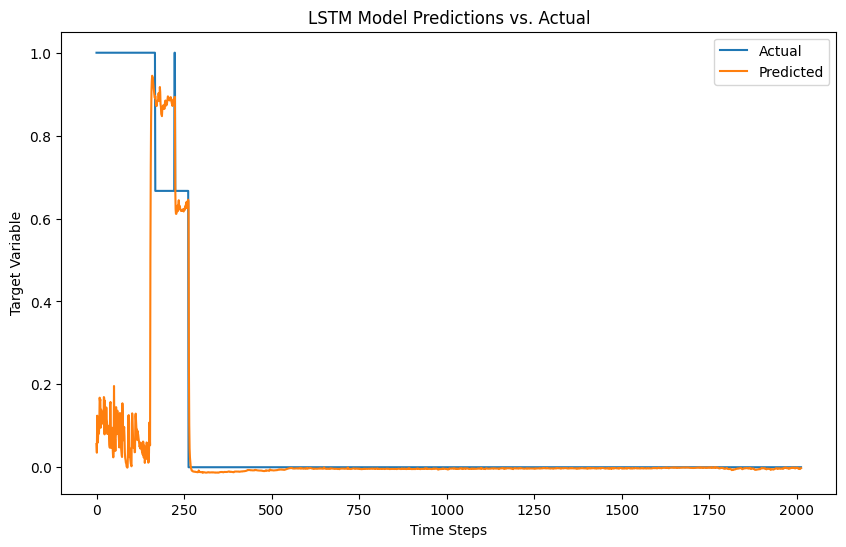

In [17]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are both in the original scale
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('LSTM Model Predictions vs. Actual')
plt.xlabel('Time Steps')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

In [18]:
# This step was mentioned before in order to compare the actual results with the LSTM predctions.
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler_target.inverse_transform(y_pred)

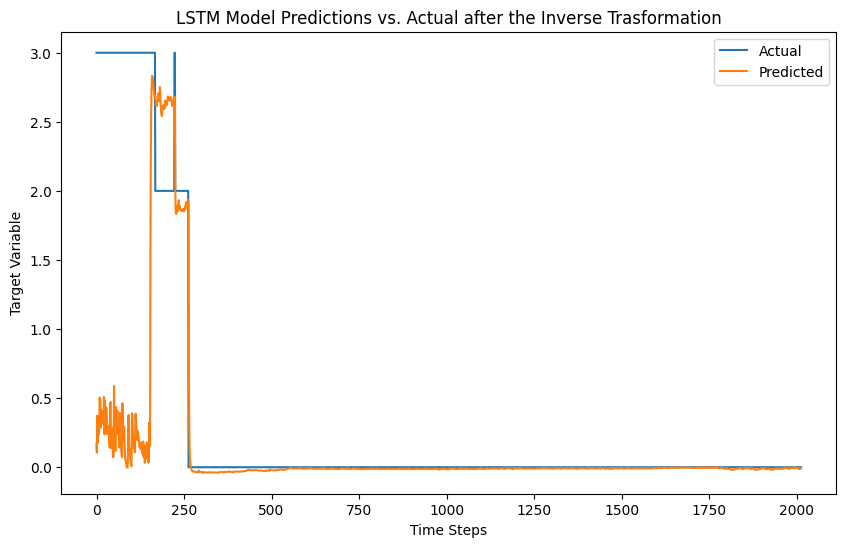

In [19]:
import matplotlib.pyplot as plt

# Double check after trasformation
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual')
plt.plot(y_pred_original, label='Predicted')
plt.title('LSTM Model Predictions vs. Actual after the Inverse Trasformation')
plt.xlabel('Time Steps')
plt.ylabel('Target Variable')
plt.legend()
plt.show()